# Logistická regrese

Úloha zaměřená na implementaci logistické regrese metodou SGD.

V případě klasifikace požaduje výstup systému ve smyslu rozhodnutí o příslušnosti k jedné ze dvou definovaných tříd. Přiřadíme datům z jedné třídy požadovanou výstupní hodnotu +1 a datům z druhé třídy 0 (příp. -1)

**Nechceme aproximovat body, ale separovat třídy!**


## Binární lineární klasifikátor pomocí logistické regrese
Umí klasifikovat jen třídy separovatelné lineárně (přimkou).

### Data

Data reprezentují výsledky zkoušky A a B a rozhodnutí o přijetí studenta na VŠ (křížek – neúspěch; hvezdička – úspěch). 

In [32]:
import numpy as np
import usu


In [33]:
npzfile = np.load('data/data_06_lr.npz')
npzfile.files


['data', 'ref']

In [34]:
data = npzfile['data']
ref = npzfile['ref']
data.shape, ref.shape


((100, 2), (100, 1))

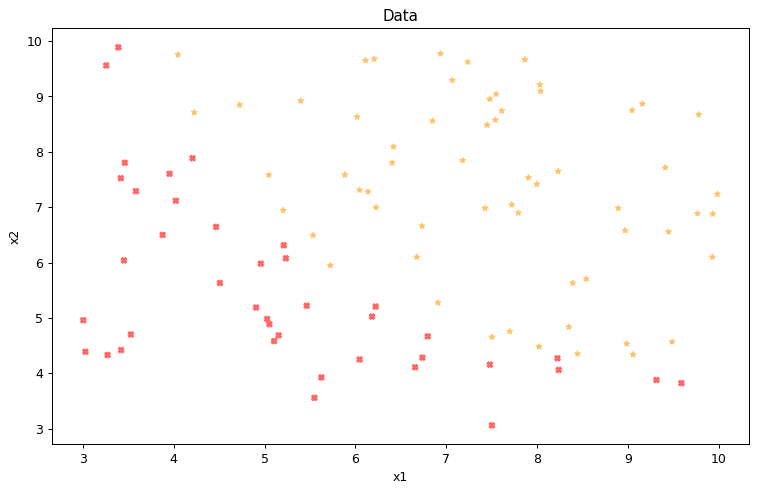

In [35]:
usu.drawSoftmax(data, ref)


### Opakování z matematiky 

- Obecný tvar rovnice přimky v prostoru o souřadnicích $x_0$ ... $x_n$ má tvar:
    $$ w_0 x_0 + w_1 x_1 + ... + w_n x_n + b = \sum_{i=0}^{n} w_i x_i + b = w^T x + b = x^T w + b = 0 $$

kde $w$ je normalový vektor (kolmý na směr přímky), 

$b$ je bias,  souvisí s posunem přímky od počátku,

$w^T x$ je skalární součin vektorů $w$ a $x$

- Bias $b$ taky můžeme označit jako $w_{n+1}$, pak platí:
$$ w_0 x_0 + w_1 x_1 + ... + w_n x_n + w_{n+1} = \sum_{i=0}^{n} w_i \tilde{x_i} = w^T \tilde{x} = \tilde{x}^T w = 0 $$

kde $\tilde{x}$ je $x$ rozšířená o jeden sloupec s hodnotami 1, např. pro 2D:

$$
    x = 
        \begin{bmatrix}
        x_0 & x_1 \\
        \end{bmatrix} 
    \implies
        \tilde{x} = 
        \begin{bmatrix}
        x_0 & x_1 & 1 \\
        \end{bmatrix} 
$$

- Poloha bodu vůči přímce ve 2D:
Orientovaná vzdálenost $d$ bodu $x$ od přímky s parametry $w$:
$$ d = \frac{w_0 x_0 + w_1 x_1 + b}{ \sqrt{w_0^2 + w_1^2}} $$

Bod $x$ leží ve vzdálenosti $d$:
- ve směru vektoru $w$ (nad přímkou): $d > 0$, tedy $w^T x + b > 0$
- proti směru vektoru $w$ (pod přímkou): $d < 0$, tedy $w^T x + b < 0$
- přímo na přímce: $d = 0$, tedy $w^T x + b = 0$



### Sigmoida
$$ sigmoid(u) = \sigma (u) = \frac{e^u}{1+e^u} = \frac{1}{1+e^{-u}} $$

kde $u = w^T \tilde{x}$


Vlastnosti:
- definiční obor: ($-\infty$, $+\infty$)
- obor hodnot: (0,1)
- $ \sigma (u) > 0.5 $ pro $u>0$, $ \sigma (u) < 0.5 $ pro $u<0$


- Pokud je hodnota na výstupu sigmoidy $\geq$ 0.5, přiřadíme bod ke třídě 1.
- Pokud je hodnota na výstupu sigmoidy < 0.5, přiřadíme bod ke třídě 0.


### Výpočet $\theta$

#### Pomocí sumy:

$$ \theta_{t+1} = \theta_{t} - \alpha \sum_{i=0}^{N} {x_i} (\sigma(x_i^T \theta_t) - y_i) $$  
kde $\alpha$ je velikost kroku (learning rate), $y_i \in {0,1}$


#### Pomocí  matice:
Maticová implementace je řádově výpočetně efektivnější bez použití cyklu for.

$$ \theta_{t+1} = \theta_{t} - \alpha X^T (\sigma(X \theta_t) - y) $$  
matice $X$ obsahuje v káždém sloupci jeden rozšířený vektor $x_i$


#### Výpočet $\theta$ s funkcionalitou pro regularizaci:
$$ \theta_{t+1} = \theta_{t}(1 - \alpha \lambda) - \alpha \sum_{i=0}^{N} {x_i} (\sigma(x_i^T \theta_t) - y_i) $$  

nebo
$$ \theta_{t+1} = \theta_{t} (1 - \alpha \lambda) - \alpha X^T (\sigma(X \theta_t) - y) $$  



#### Postup:
1. Parametr $\theta$ (resp. váhy $w$ a bias $b$) se inicializuje na malé náhodné hodnoty nebo na nuly
2. Na vstup se přivedou všechna trénovací data a na výstupu se tím pádem objeví posloupnost nul a jedniček (obsahuje chyby)
3. Na základě chyb se upraví hodnoty vah
4. Kroky 2. a 3. se postupně opakují, dokud dostatečně klesá chybovost klasifikátoru (nebo podle počtu iterací)


In [36]:
def sigmoid(z):
    """
    vstupem muze byt skalar, vektor, nebo matice 
    """
    
    #################################################################

    z_new = np.ndarray(shape=(len(z), len(z[0])))

    if isinstance(z, (int, float)):
        return 1 / (1 + np.exp(-z))
    else:
        for i in range(len(z)):
            for j in range(len(z[i])):
                z_new[i][j] = 1 / (1 + np.exp(-z[i][j]))

        return z_new

    
    #################################################################

usu.checkSigmoid(sigmoid) #kontrola vystupu, output musi byt True

True

In [37]:
def thetaSGD(data, classes, alpha=0.001, iterations=10000, lmbd=0):
    """
    alpha = learning rate
    """
    #################################################################
    # ZDE DOPLNIT
    
    # pridani prvniho sloupce
    X = np.c_[np.ones((data.shape[0], 1)), data]

    #inicializace theta
    theta = np.random.rand(X.shape[1], 1)

    for i in range(iterations):
        gradient = alpha * X.T @ (sigmoid(X @ theta) - classes)
        theta = theta * (1 - alpha * lmbd) - gradient
        
    #################################################################    
    return theta


In [38]:
theta = thetaSGD(data,ref)

theta

array([[-15.28789351],
       [  1.27400662],
       [  1.21607625]])

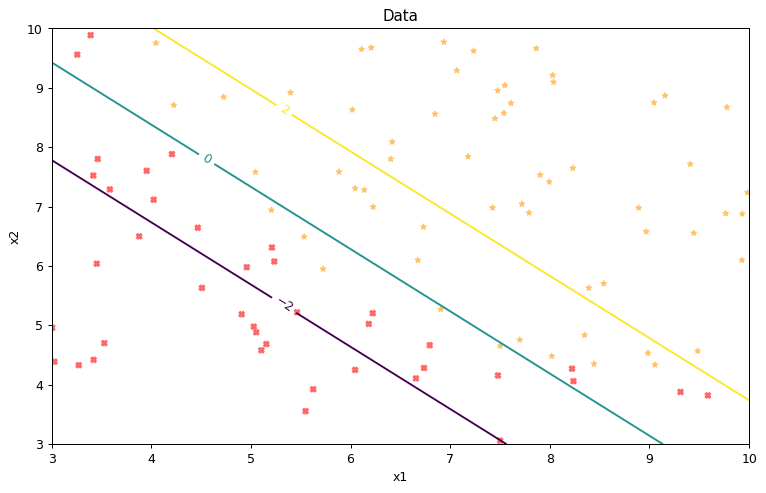

In [39]:
usu.drawSoftmax(data, ref, theta)


In [63]:
def predict(x, theta):
    #vrací hodnotu y (0 nebo 1) pro vstup theta a X 
       
    #################################################################
    # ZDE DOPLNIT
    
    y = theta.T @ x

    y = 1 if y > 0 else 0
    
    #################################################################

    return y


Rozhodněte o přijetí v případě zisku 6 a 4 bodů a nastavení parametrů: alpha = 0.001,lambda = 0.2, počet iterací = 10000:

In [66]:
#################################################################
# ZDE DOPLNIT

alpha = 0.001
lmbd = 0.2
iterations = 10000

x1 = 6
x2 = 4

y = predict(np.array([1, x1, x2]), theta)


#################################################################


In [67]:
print(y)

0
